In [1]:
import pandas as pd
import re
import os
from spherical_fields import *
import spherical_fields
import field_regularizer
import mhd_system
from settings import Settings
import matplotlib.pyplot as plt
import importlib
import astropy.units
importlib.reload(mhd_system)
importlib.reload(field_regularizer)

def read_lesur(filename):
    global data
    data = pd.read_csv(filename, skiprows=6, delimiter="\t+", engine='python')
    data.columns = [x.split(" ")[0] for x in data.columns]
    thetas = data.theta.to_numpy()
    
    cs = ScalarField(np.sqrt((data.P/data.rho).to_numpy()), -1/2, thetas)
    beta, Lambda_a_0, Rm_0 = [float(x) for x in re.findall("=(inf|[^-]+)", filename)]
    lambda_ = 3
    parameter_rep = np.concatenate([data["rho"]   , 
                                    data["vr"]    , 
                                    data["vtheta"], 
                                    data["vphi"]  ,
                                    data["Btheta"],
                                    data["Bphi"], 
                                   ])
    
    regularized_fields = field_regularizer.field_regularizer(parameter_rep, thetas, cs, beta)
    return mhd_system.mhd_system(cs, Lambda_a_0, Rm_0, lambda_), regularized_fields

#for file in os.listdir("../PPDwind"):
#    if ".dat" in file:
#        mhd_sim, regularized_fields = read_lesur("../PPDwind/" + file)
        #plt.plot(theta,cs2.v)
        #plt.semilogy(rho.theta_grid,rho.v)
        #plt.xlim(np.pi/2-0.01, np.pi/2+0.01)
#        break
file = "beta=1.0e+05-Am=1-Rm=inf.dat"
mhd_sim, regularized_fields = read_lesur("../PPDwind/" + file)

[0.09999354 0.09999354 0.09999354 ... 0.09999354 0.09999354 0.09999354]


/mnt/c/Users/rasmu/Dropbox/Uni/PUK/Code/mhd_system.py:26: RuntimeWarning: overflow encountered in exp
  Lambda_A = ScalarField(Lambda_a_0*np.exp((z/(lambda_*h))**4), -1, theta_grid, prescription="cylindrical")


In [2]:
(data.rho).sum()

182.29578819902042

In [3]:
data.theta.diff().unique()

array([      nan, 0.0013875, 0.0013875, 0.0013874, 0.0013875, 0.0013874,
       0.0013874, 0.0013875, 0.0013874, 0.001388 , 0.001387 , 0.001387 ,
       0.001388 , 0.001388 , 0.001387 ])

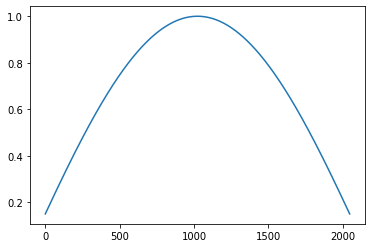

In [4]:
plt.plot(np.sin(data.theta))

(0.0, 100.0)

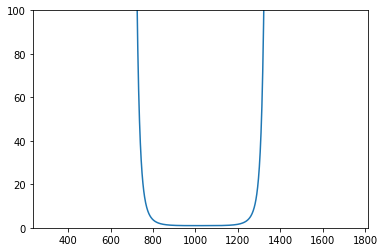

In [5]:
plt.plot(data.Lambda_A)
plt.ylim(0,100)

In [6]:
def plot_system(rho, v, B, axes):
    rho_ax, v_ax, B_ax = axes
    rho_ax.plot(rho.theta_grid, rho.v, color="k")
    rho_ax.set_title("rho")
    rho_ax.grid()
    v_ax.plot(v.theta_grid, v.v_r, color="blue")
    v_ax.plot(v.theta_grid, v.v_theta, color="red")
    v_ax.plot(v.theta_grid, v.v_phi, color="green")
    v_ax.set_title("v")
    v_ax.grid()
    v_ax.legend(["r", "theta", "phi"])
    B_ax.plot(B.theta_grid, B.v_r, color="blue")
    B_ax.plot(B.theta_grid, B.v_theta, color="red")
    B_ax.plot(B.theta_grid, B.v_phi, color="green")
    B_ax.set_title("B")
    B_ax.grid()
    B_ax.legend(["r", "theta", "phi"])

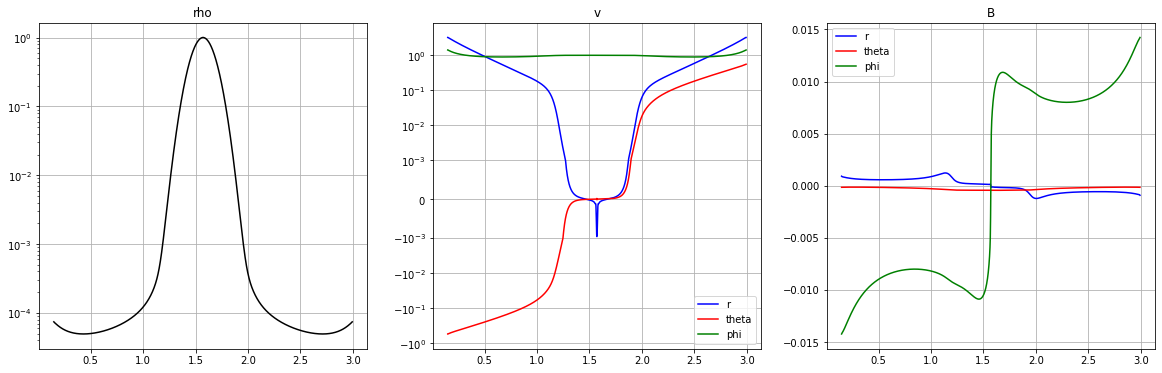

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
plot_system(regularized_fields.rho, regularized_fields.v,
            regularized_fields.B, axes)
axes[0].set_yscale("log")
axes[1].set_yscale("symlog", linthresh=0.001)
#axes[1].set_xlim(np.pi/2-0.1, np.pi/2+0.1)

beta=1.0e+05-Am=1-Rm=inf.dat
[0.09999354 0.09999354 0.09999354 ... 0.09999354 0.09999354 0.09999354]


(-0.01, 0.01)

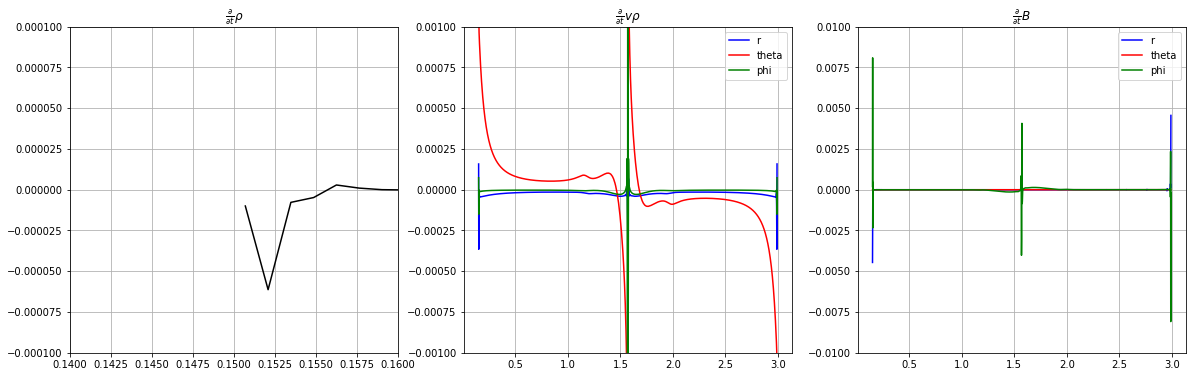

In [8]:
importlib.reload(mhd_system)
importlib.reload(field_regularizer)
import units
importlib.reload(units)

np.seterr("raise", over="ignore", under="ignore")
print(file)
mhd_sim, regularized_fields = read_lesur("../PPDwind/" + file)
rho = regularized_fields.rho
v = regularized_fields.v
B = regularized_fields.B
fig, axes = plt.subplots(1, 3, figsize=(20,6))
plot_system(mhd_sim.get_rho_dt(rho, v), mhd_sim.get_rho_v_dt(rho, v, B), mhd_sim.get_B_dt(rho, v, B), axes)
axes[0].set_title(r"$\frac{\partial}{\partial t}\rho$")
axes[1].set_title(r"$\frac{\partial}{\partial t}v\rho$")
axes[2].set_title(r"$\frac{\partial}{\partial t}B$")
#axes[2].set_yscale("symlog", linthresh=1e-5)
axes[0].set_ylim(-0.0001,0.0001)
axes[0].set_xlim(0.14,0.16)
axes[1].set_ylim(-0.001,0.001)
axes[2].set_ylim(-0.01,0.01)

In [9]:
v.theta_grid[0]

0.14791870000000004

In [280]:
import scipy.integrate
np.seterr("warn", over="ignore", under="ignore")

def integrate_streamline(r0, theta0, v, rho, cs):    
    #pos_dust (r, theta)
    #vel_dust (r, theta, phi)
    # all linear, not angular velocities
    def acceleration(t, state):  
        pos_dust = state[:2]
        vel_dust = state[2:]
        # fomulas taken from https://en.wikipedia.org/wiki/Vector_fields_in_cylindrical_and_spherical_coordinates
        carthesian_to_spherical = lambda theta, vec: np.array([ 
                np.sin(theta) * vec[0] + np.cos(theta) * vec[2],
                np.cos(theta) * vec[0] - np.sin(theta) * vec[2],
                vec[1],
            ])
        spherical_to_carthesian = lambda theta, vec: np.array([ 
                np.sin(theta) * vec[0] + np.cos(theta) * vec[1],
                vec[2],
                np.cos(theta) * vec[0] - np.sin(theta) * vec[1],
            ])
        r, theta = pos_dust
        v_cart_dust = spherical_to_carthesian(theta, vel_dust)
        v_cart_gas = spherical_to_carthesian(theta, v.at_coord(r,theta))
        
        ## Drag acceleration
        g_per_cm2 = units.units.kg*1e-3*(units.units.m*1e-2)**-2
        dust_size = 1e1 * g_per_cm2 # particle size * density measured in g/cm^2
        ts = dust_size / (rho * cs).at_coord(1,theta)
        acc_cart_drag = (v_cart_gas - v_cart_dust) / ts
        acc_pol_drag = 0*carthesian_to_spherical(theta, acc_cart_drag)
        
        ## Gravitational acceleration (in spherical coords)
        acc_pol_G = np.array([-units.constants.GM/r**2,np.zeros_like(r),np.zeros_like(r)])
        
        ## Centrifugal acceleration (in spherical coords, coordinate rotating with particle)
        omega = vel_dust[2]/r
        acc_pol_cent = np.array([omega**2*r * np.sin(theta), omega**2*r * np.cos(theta),np.zeros_like(r)])
        ret = np.vstack([vel_dust[0], vel_dust[1]/r, acc_pol_G + acc_pol_drag + acc_pol_cent])
        #if not np.isfinite(ret).all():
        print("state:")
        print(state)
        print("ret:")
        print(ret)
        print(f"{omega**2*r=}")
        #print("gas velocity:", v.at_coord(r,theta))
        print("Gravity:\n", acc_pol_G, "\nDrag:\n", acc_pol_drag, "\nCentrifugal:\n", acc_pol_cent)
        return np.vstack([vel_dust[0], vel_dust[1]/r, acc_pol_G + acc_pol_drag + acc_pol_cent])
        
    stopper1    = lambda t, x: np.abs((np.tan(np.pi/2-x[1]))*x[0] - 60)
    stopper2    = lambda t, x: min(x[1]-v.theta_grid[0], v.theta_grid[-1]-x[1]) - 0.04
    stopper1.terminal = True
    stopper2.terminal = True
    res = scipy.integrate.solve_ivp(acceleration, t_span=(0,1e5), y0=np.array([1, np.pi/2, *v.at_coord(1, np.pi/2)]), method="BDF", vectorized=True, events=[stopper1, stopper2])
    #print(acceleration(0,np.array([1, np.pi/2-0.1, *v.at_coord(1, np.pi/2-0.1)])[:,None]))
    #res = scipy.integrate.solve_ivp(acceleration, t_span=(0,1e4), y0=np.array([1, np.pi/2-0.1, 0,0,0]), method="BDF", vectorized=True, events=[stopper1, stopper2])
    return res
res = integrate_streamline(0.01, 0, v, rho, mhd_sim.cs)

state:
[[ 1.00000000e+00]
 [ 1.57079633e+00]
 [-9.62530849e-04]
 [ 3.83719020e-09]
 [ 9.87296600e-01]]
ret:
[[-9.62530849e-04]
 [ 3.83719020e-09]
 [-2.52076511e-02]
 [ 5.96865036e-17]
 [ 0.00000000e+00]]
omega**2*r=array([0.97475458])
Gravity:
 [[-0.99996223]
 [ 0.        ]
 [ 0.        ]] 
Drag:
 [[0.]
 [0.]
 [0.]] 
Centrifugal:
 [[9.74754576e-01]
 [5.96865036e-17]
 [0.00000000e+00]]
state:
[[ 9.99998652e-01]
 [ 1.57079633e+00]
 [-9.97830518e-04]
 [ 3.83719020e-09]
 [ 9.87296600e-01]]
ret:
[[-9.97830518e-04]
 [ 3.83719537e-09]
 [-2.52090329e-02]
 [-5.23777105e-12]
 [ 0.00000000e+00]]
omega**2*r=array([0.97475589])
Gravity:
 [[-0.99996492]
 [ 0.        ]
 [ 0.        ]] 
Drag:
 [[ 0.]
 [-0.]
 [ 0.]] 
Centrifugal:
 [[ 9.74755890e-01]
 [-5.23777105e-12]
 [ 0.00000000e+00]]
state:
[[ 1.00000000e+00]
 [ 1.57079633e+00]
 [-9.62530849e-04]
 [ 3.83719020e-09]
 [ 9.87296600e-01]]
ret:
[[-9.62530849e-04]
 [ 3.83719020e-09]
 [-2.52076511e-02]
 [ 5.96865036e-17]
 [ 0.00000000e+00]]
omega**2*r=arr

KeyboardInterrupt: 

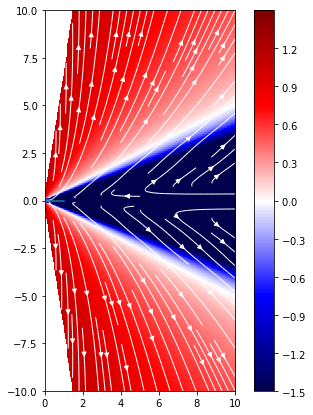

In [279]:
import matplotlib.colors
plt.figure(figsize=(7,7))
Rs, zs = np.meshgrid(np.linspace(0.1,10,200), np.linspace(-10,10,200))
thetas = np.pi/2-np.arctan(zs/Rs)
rs = np.hypot(Rs, zs)
dr = np.interp(thetas,v.theta_grid,v.v_r, left=np.nan, right=np.nan)*rs**v.a
dt = np.interp(thetas,v.theta_grid,v.v_theta, left=np.nan, right=np.nan)*rs**v.a
dphi = np.interp(thetas,v.theta_grid,v.v_phi, left=np.nan, right=np.nan)*rs**v.a
cs = np.interp(thetas,mhd_sim.cs.theta_grid,mhd_sim.cs.v, left=np.nan, right=np.nan)*rs**mhd_sim.cs.a
plt.streamplot(Rs, zs, dr * np.sin(thetas) + dt * np.cos (thetas), dr * np.cos(thetas) - dt * np.sin(thetas), color="w", linewidth=1)
plt.imshow(np.log10(np.sqrt(dr**2+dt**2)/cs),extent=(0,10,-10,10), norm=matplotlib.colors.Normalize(-1.5,1.5), cmap="seismic")
plt.colorbar(ticks=np.arange(-1.5, 1.5, 0.3), format="$%.1f$")
plt.plot(np.cos(np.pi/2-res.y[1])*res.y[0], np.sin(np.pi/2-res.y[1])*res.y[0])
#plt.axis((0,10,-10,10))

(0.0, 10.0, -10.0, 10.0)

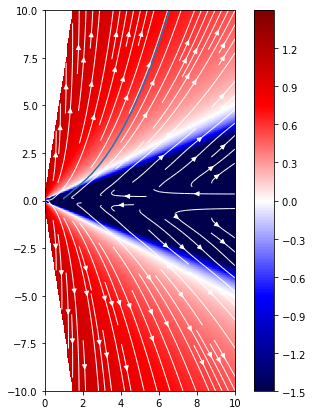

In [138]:
import matplotlib.colors
plt.figure(figsize=(7,7))
Rs, zs = np.meshgrid(np.linspace(0.1,10,200), np.linspace(-10,10,200))
thetas = np.pi/2-np.arctan(zs/Rs)
rs = np.hypot(Rs, zs)
dr = np.interp(thetas,v.theta_grid,v.v_r, left=np.nan, right=np.nan)*rs**v.a
dt = np.interp(thetas,v.theta_grid,v.v_theta, left=np.nan, right=np.nan)*rs**v.a
dphi = np.interp(thetas,v.theta_grid,v.v_phi, left=np.nan, right=np.nan)*rs**v.a
cs = np.interp(thetas,mhd_sim.cs.theta_grid,mhd_sim.cs.v, left=np.nan, right=np.nan)*rs**mhd_sim.cs.a
plt.streamplot(Rs, zs, dr * np.sin(thetas) + dt * np.cos (thetas), dr * np.cos(thetas) - dt * np.sin(thetas), color="w", linewidth=1)
plt.imshow(np.log10(np.sqrt(dr**2+dt**2)/cs),extent=(0,10,-10,10), norm=matplotlib.colors.Normalize(-1.5,1.5), cmap="seismic")
plt.colorbar(ticks=np.arange(-1.5, 1.5, 0.3), format="$%.1f$")
plt.plot(np.cos(np.pi/2-res.y[1])*res.y[0], np.sin(np.pi/2-res.y[1])*res.y[0])
plt.axis((0,10,-10,10))

(-1.0, 1.0)

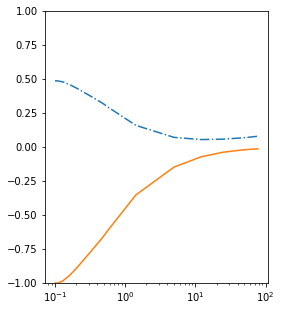

In [14]:
import scipy.integrate as integrate
plt.figure(figsize=(4,5))

z = np.sin(np.pi/2-res.y[1])*res.y[0]

# Kinetic:
plt.plot(z, np.sum(v.at_coord(*res.y)**2,0)/2, "-.")

# Gravitational:
R = np.cos(np.pi/2-res.y[1])*res.y[0]
plt.plot(z, -1/np.sqrt(R**2+z**2), "-")

# Magnetic:
#kappa = 4*np.pi*
#omega = Omega-
#R = np.cos(np.pi/2-res.y[1])*res.y[0]
#plt.plot(z, -1/np.sqrt(R**2+z**2), "-")

# Thermal:
P_grad = (mhd_sim.cs**2*rho).grad()
integrand = -(P_grad/rho[1:-1]).at_coord(*res.y)
v_eval = v.at_coord(*res.y)
v_unit = v_eval / (v_eval**2).sum(0)**0.5

x = (integrand*v_eval).sum(0)[:-1] * np.diff(res.t)
plt.plot(z[:-1], np.cumsum(x[::-1])[::-1])
plt.xscale("log")
plt.ylim(-1,1)

In [140]:
rs.shape

(200, 200)

[0.09999354 0.09999354 0.09999354 ... 0.09999354 0.09999354 0.09999354]
0 out of 100, total squared error 15531.646464358333
10 out of 100, total squared error 15507.19959824124
20 out of 100, total squared error 15482.779071753708
30 out of 100, total squared error 15458.390934187293
40 out of 100, total squared error 15434.041215841442
50 out of 100, total squared error 15409.735910479943
60 out of 100, total squared error 15385.480958242857
70 out of 100, total squared error 15361.28222908509
80 out of 100, total squared error 15337.145506807394
90 out of 100, total squared error 15313.076473740512


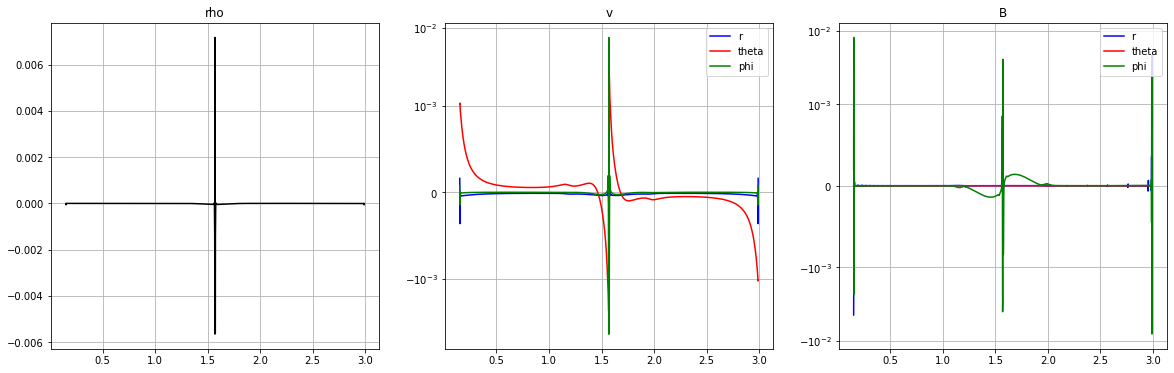

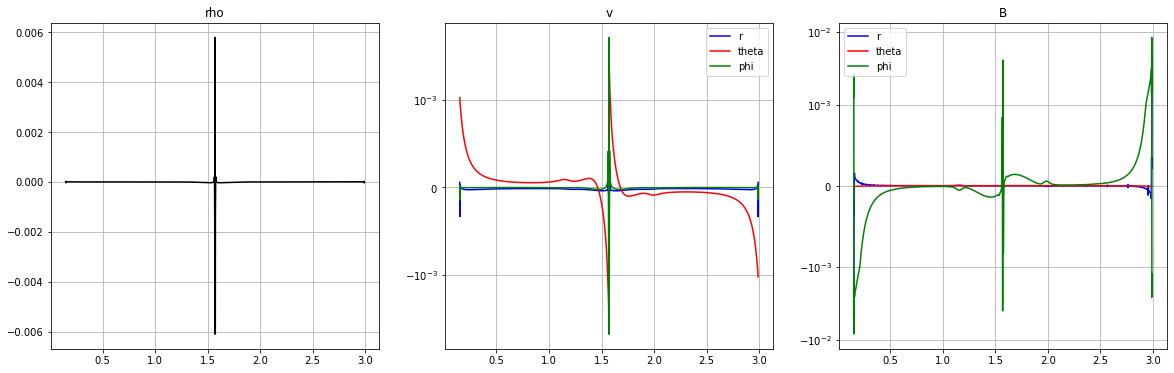

In [100]:
import warnings
warnings.filterwarnings("error", category=np.VisibleDeprecationWarning) 

mhd_sim, regularized_fields = read_lesur("../PPDwind/" + file)

fig, axes = plt.subplots(1, 3, figsize=(20,6))
plot_system(mhd_sim.get_rho_dt(regularized_fields.rho, regularized_fields.v), 
            mhd_sim.get_rho_v_dt(regularized_fields.rho, regularized_fields.v, regularized_fields.B), 
            mhd_sim.get_B_dt(regularized_fields.rho, regularized_fields.v, regularized_fields.B), axes)
axes[1].set_yscale("symlog", linthresh=0.001)
axes[2].set_yscale("symlog", linthresh=0.001)

prev_grad = np.zeros_like(regularized_fields.parameter_rep)
lr = 1e-5
momentum = 0.0
loops = 100
for i in range(loops):
    rho = regularized_fields.rho
    v = regularized_fields.v
    B = regularized_fields.B
    curr_grad = regularized_fields.gradient_to_parameter_rep(mhd_sim.get_rho_dt(rho, v), mhd_sim.get_rho_v_dt(rho, v, B), mhd_sim.get_B_dt(rho, v, B))
    grad = prev_grad * momentum + curr_grad * (1-momentum)
    prev_grad = grad
    regularized_fields.update_parameters(regularized_fields.parameter_rep+lr*grad)
    if i% (loops//10) == 0:
        print(f"{i} out of {loops}, total squared error {np.sum(curr_grad**2)}")
    
fig, axes = plt.subplots(1, 3, figsize=(20,6))
plot_system(mhd_sim.get_rho_dt(regularized_fields.rho, regularized_fields.v), 
            mhd_sim.get_rho_v_dt(regularized_fields.rho, regularized_fields.v, regularized_fields.B), 
            mhd_sim.get_B_dt(regularized_fields.rho, regularized_fields.v, regularized_fields.B), axes)
axes[1].set_yscale("symlog", linthresh=0.001)
axes[2].set_yscale("symlog", linthresh=0.001)